In [1]:
import pandas as pd
from google.oauth2 import service_account
import pandas_gbq
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time

In [2]:
#Query and process data to cloud

credentials = service_account.Credentials.from_service_account_file('C:/Users/OMISTAJA/Desktop/Python/apt-summer-378616-8d17746c9fd8.json')
client = bigquery.Client(credentials=credentials)

table_id = "apt-summer-378616.assingment_4.daily_user_data_240223"

job_config = bigquery.QueryJobConfig(destination=table_id)
job_config.write_disposition = "WRITE_TRUNCATE"

sql = """
SELECT
event_date, 
user_pseudo_id,
device.mobile_brand_name as device,
device.operating_system as os,
geo.country as location,
SUM(ecommerce.purchase_revenue) as revenue,
count(*) as total_events
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE _TABLE_SUFFIX BETWEEN '20210115' AND '20210131'
GROUP BY 1,2,3,4,5
ORDER BY revenue DESC;
"""

query_job = client.query(sql, job_config=job_config)
query_job.result()

print("Query results loaded to the table {}".format(table_id))

Query results loaded to the table apt-summer-378616.assingment_4.daily_user_data_240223


In [3]:
#Import data from cloud

projectid = "apt-summer-378616"

sql = """
SELECT
event_date,  
user_pseudo_id,
total_events,
location,
SUM(revenue) as revenue
FROM `apt-summer-378616.assingment_4.daily_user_data_240223`
GROUP BY 1,2,3,4
ORDER BY user_pseudo_id DESC
"""
df_raw = pd.read_gbq(sql,projectid,credentials=credentials)
print("Data imported from cloud {}". format(table_id))

Data imported from cloud apt-summer-378616.assingment_4.daily_user_data_240223


In [4]:
#Sort and convert event_date to datetime format 
df_raw['event_date'] = sorted(pd.to_datetime(df_raw['event_date'], format = '%Y%m%d'))

#Setting startDay and endDay to right output format
days = len(df_raw)
startDay = df_raw['event_date'][0].strftime("%x")
endDay = df_raw['event_date'][days -1].strftime("%x")

In [5]:
#Max,Min,Average setup for events and revenues

#events
MaxEvent = (np.max(df_raw['total_events']))
MinEvent = (np.min(df_raw['total_events']))
AverageEvents = round(np.mean(df_raw['total_events']))

#revenues
MaxRevenue = round(np.max(df_raw['revenue']))
MinRevenue = round(np.min(df_raw['revenue']))
AverageRevenues = round(np.mean(df_raw['revenue']))

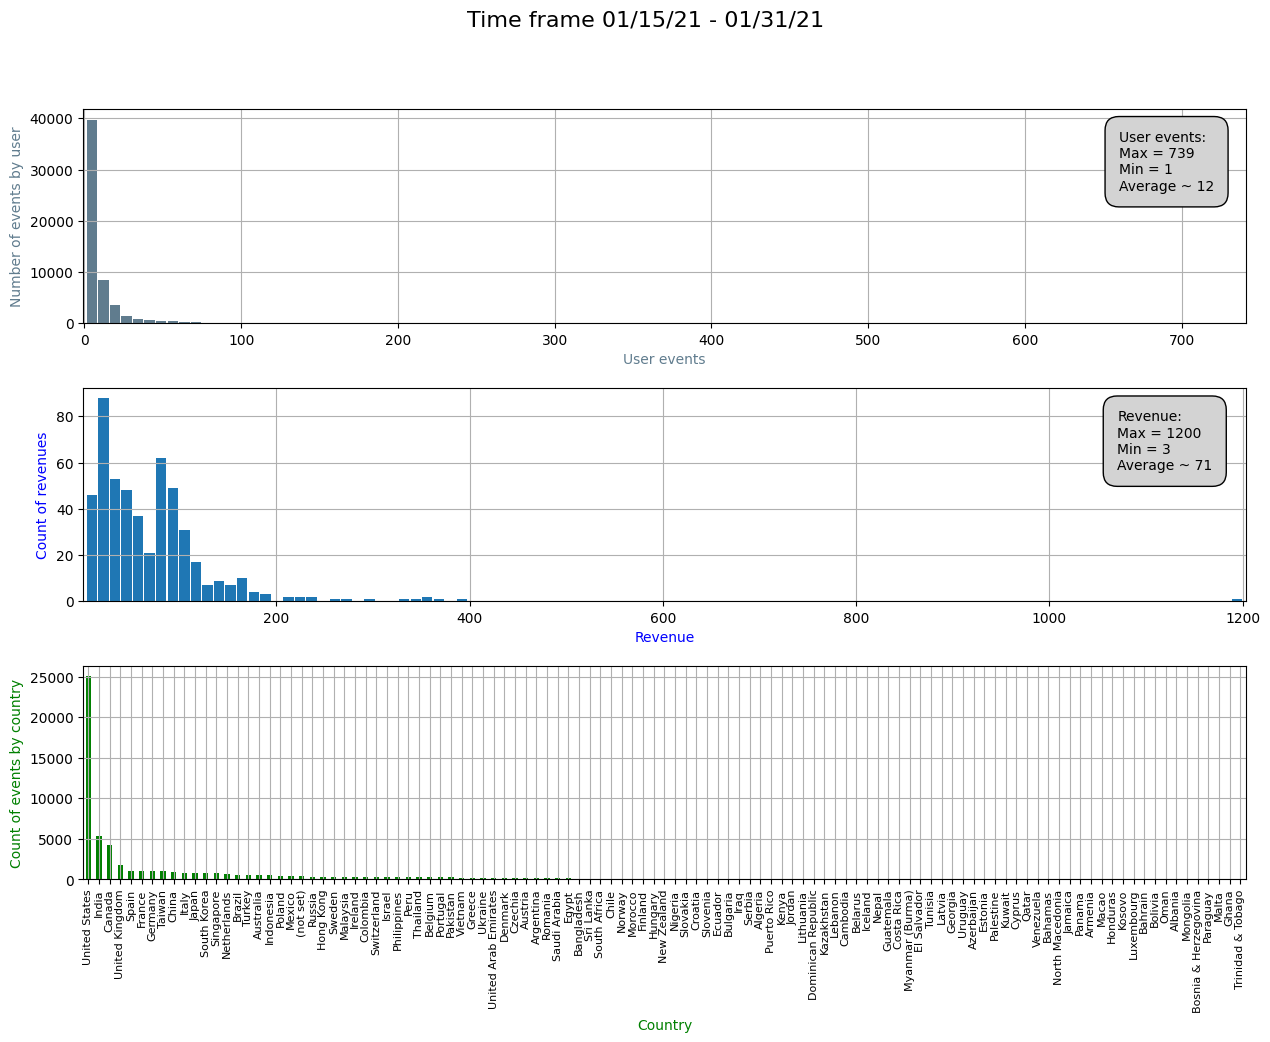

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=1 ,figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f"Time frame {startDay} - {endDay}", fontsize = "16")

#events per user
plt.subplot(3,1,1)
plt.text(660,26000,f"User events:\nMax = {MaxEvent}\nMin = {MinEvent}\nAverage ~ {AverageEvents}",bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=1'))
plt.hist(df_raw['total_events'], bins=100, rwidth=0.9,color='#607c8e')
plt.ylabel('Number of events by user', color='#607c8e')
plt.xlabel('User events', color='#607c8e')
plt.margins(x=0.003)
plt.grid(True)

#distribution of revenue
plt.subplot(3,1,2)
plt.text(1070,57,f"Revenue:\nMax = {MaxRevenue}\nMin = {MinRevenue}\nAverage ~ {AverageRevenues}",bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=1'))
plt.hist(df_raw['revenue'],bins=100, rwidth=0.9)
plt.ylabel('Count of revenues', color="blue")
plt.xlabel('Revenue', color="blue")
plt.margins(x=0.003)
plt.grid(True)

#distiribution of countries
plt.subplot(3,1,3)
plt.ticklabel_format(style='plain')
df_raw.groupby('location')['total_events'].count().sort_values(ascending=False)[:109].plot(kind='bar',color = "green")  #109 countries
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Count of events by country', color="green")
plt.xlabel('Country', color="green")
plt.grid(True)
plt.show()